#### Assignmet 1 - Computer Vision, Digit Classification

#### Imports

In [44]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [66]:
def create_results_dataframe(model_name,training_history,y_true,y_pred):

    training_df = pd.DataFrame(training_history.history)
    model_results_df = pd.DataFrame(training_df.iloc[-1,:]).transpose()
    model_results_df = model_results_df.reset_index().rename(columns={'index':'epoch'})
    model_results_df['model'] = model_name
    model_results_df = model_results_df.iloc[:,[-1,0,1,2]]
    model_results_df['precision_micro'] = precision_score(y_true,y_pred,average='micro')
    model_results_df['recall_micro'] = recall_score(y_true,y_pred,average='micro')
    model_results_df['f1_score_micro'] = f1_score(y_true,y_pred,average='micro')

    return(model_results_df)

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

#### Import MNIST dataset, creating training and test sets

In [3]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

#### Exploratory Data Analysis

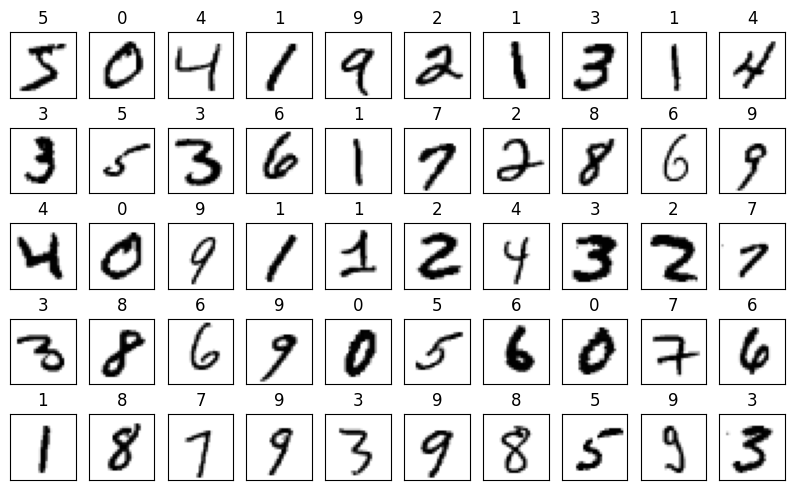

In [4]:
# First 50 images
fig = plt.figure(figsize = (10, 6))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

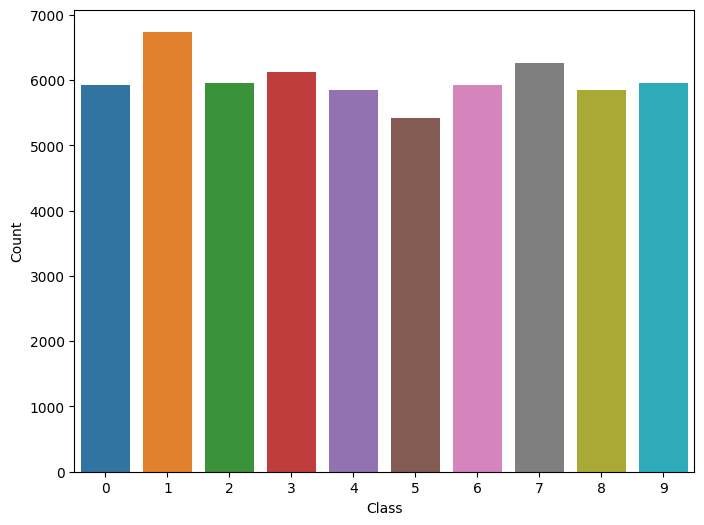

In [5]:
# Frequency chart of classificatinos
plt.figure(figsize = (8 ,6))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [6]:
# Example of sample input
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2027]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  77 254 220   0   0   0   0   0   0   0   4  60  48 118  25   0   0   0   0   0   0   0   0]
 [  0   0   0   0  37 218 253 250 234 234 234 234 234 234 234 234 244 242 253 18

#### Data pre-processing

In [7]:
# Apply one hot encoding to the labels, creating binary variables for 0-9 indicating classification

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:4,]))

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)
First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
# Reshape the 28x28 inputs to 1x784

# Reshape the sets:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


In [9]:
# Normalize the inputs by dividing values by 255 (max greyscale value)

x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

#### Experiment Set 1

In [ ]:
k.clear_session()

#### Experiment 1 - MLP with one hidden layer (1)

In [135]:
# Experiment 1

# Step 1 - Create model architecture using the Sequential class
model_one = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_one.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy','AUC'])

# Step 3 - Traing the model, saving the best model
training_one = history = model_one.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_one = tf.keras.models.load_model("model_one.h5")

# Step 4 - Predict the test set
preds_one = model_one.predict(x_test_norm)
preds_one = np.argmax(preds_one, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 302us/step


#### Experiment 2 - MLP with one hidden layer (2)

In [136]:
# Experiment 2

# Step 1 - Create model architecture using the Sequential class
model_two = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_two.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_two = history = model_two.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_two = tf.keras.models.load_model("model_two.h5")

# Step 4 - Predict the test set
preds_two = model_two.predict(x_test_norm)
preds_two = np.argmax(preds_two, axis=1)

313/313 [==============================] - 0s 325us/step


#### Experiment 3 - MLP with one hidden layer (10)

In [137]:
# Experiment 3

# Step 1 - Create model architecture using the Sequential class
model_three = Sequential([
    Dense(input_shape=[784], units=10, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_three.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_three = history = model_three.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_three = tf.keras.models.load_model("model_three.h5")

# Step 4 - Predict the test set
preds_three = model_three.predict(x_test_norm)
preds_three = np.argmax(preds_three, axis=1)

313/313 [==============================] - 0s 339us/step


#### Experiment 4 - MLP with one hidden-layer (128)

In [138]:
# Experiment 4

# Step 1 - Create model architecture using the Sequential class
model_four = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_four.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_four = model_four.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_four = tf.keras.models.load_model("model_four.h5")

# Step 4 - Predict the test set
preds_four = model_four.predict(x_test_norm)
preds_four = np.argmax(preds_four, axis=1)

313/313 [==============================] - 0s 381us/step


#### Experiment Set 1 Results

In [100]:
experiment_set_1_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])
experiment_1_results = create_results_dataframe('model_one',training_one,y_test,preds_one)
experiment_2_results = create_results_dataframe('model_two',training_two,y_test,preds_two)
experiment_3_results = create_results_dataframe('model_three',training_three,y_test,preds_three)
experiment_4_results = create_results_dataframe('model_four',training_four,y_test,preds_four)
experiment_set_1_results = pd.concat([experiment_set_1_results,experiment_1_results,experiment_2_results,experiment_3_results,experiment_4_results]).reset_index(drop=True)
experiment_set_1_results

,model,epoch,accuracy,loss,precision_micro,recall_micro,f1_score_micro
0,model_one,17,0.348188,1.635586,0.3529,0.3529,0.3529
1,model_two,17,0.673917,1.015815,0.6754,0.6754,0.6754
2,model_three,6,0.924833,0.302875,0.9256,0.9256,0.9256
3,model_four,9,0.972562,0.144069,0.9697,0.9697,0.9697


In [190]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    plt.ylabel('true label')
    plt.xlabel('predicted label')

<Axes: >

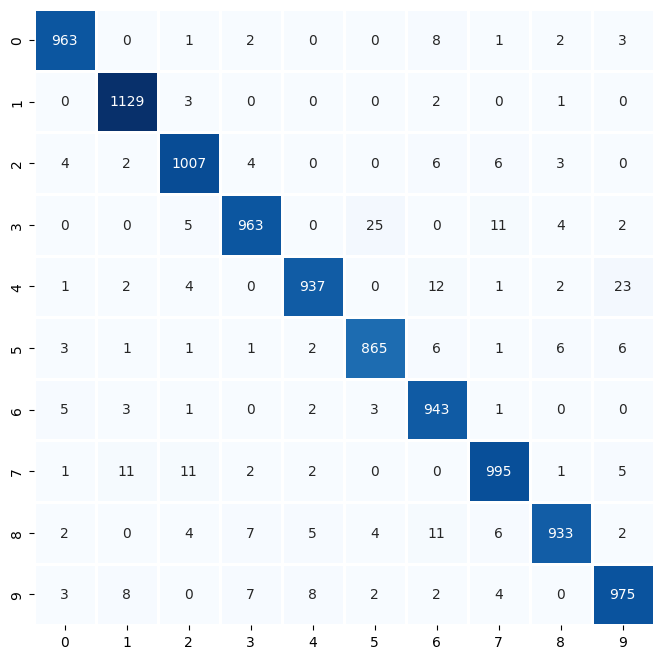

In [214]:
matrix_one = confusion_matrix(y_test,preds_one)
matrix_two = confusion_matrix(y_test,preds_two)
matrix_three = confusion_matrix(y_test,preds_three)
matrix_four = confusion_matrix(y_test,preds_four)

fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(matrix_one, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
# sns.heatmap(matrix_two, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
# sns.heatmap(matrix_three, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
sns.heatmap(matrix_four, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')

#### Experiment Set 2

#### Experiment 5 - MLP with one hidden layer (128), adam optimizer

In [139]:
# Experiment 5

# Step 1 - Create model architecture using the Sequential class
model_five = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_five.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_five = model_five.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_five = tf.keras.models.load_model("model_five.h5")

# Step 4 - Predict the test set
preds_five = model_five.predict(x_test_norm)
preds_five = np.argmax(preds_five, axis=1)

313/313 [==============================] - 0s 401us/step


#### Experiment 6 - MLP with two hidden layers (128, 64), rmsprop optimizer

In [140]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_six = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_six.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_six = model_six.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_six = tf.keras.models.load_model("model_six.h5")

# Step 4 - Predict the test set
preds_six = model_six.predict(x_test_norm)
preds_six = np.argmax(preds_six, axis=1)

313/313 [==============================] - 0s 409us/step


#### Experiment 7 - MLP with two hidden layers (128, 64), adam optimizer

In [187]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_seven = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_seven.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_seven = model_seven.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_seven = tf.keras.models.load_model("model_seven.h5")

# Step 4 - Predict the test set
preds_seven = model_seven.predict(x_test_norm)
preds_seven = np.argmax(preds_seven, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 413us/step


#### Experiment 8 - MLP with three hidden layers (128, 64, 32), adam optimizer

In [142]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_eight = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[64],units=32,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_eight.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_eight = model_eight.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_eight = tf.keras.models.load_model("model_eight.h5")

# Step 4 - Predict the test set
preds_eight = model_eight.predict(x_test_norm)
preds_eight = np.argmax(preds_eight, axis=1)

313/313 [==============================] - 0s 418us/step


#### Experiment Set 2 Results

In [114]:
experiment_set_2_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])
experiment_5_results = create_results_dataframe('model_five',training_five,y_test,preds_five)
experiment_6_results = create_results_dataframe('model_six',training_six,y_test,preds_six)
experiment_7_results = create_results_dataframe('model_seven',training_seven,y_test,preds_seven)
experiment_8_results = create_results_dataframe('model_eight',training_eight,y_test,preds_eight)
experiment_set_2_results = pd.concat([experiment_set_2_results,experiment_5_results,experiment_6_results,experiment_7_results,experiment_8_results]).reset_index(drop=True)
experiment_set_2_results

,model,epoch,accuracy,loss,precision_micro,recall_micro,f1_score_micro
0,model_five,8,0.974479,0.158447,0.9730,0.9730,0.9730
1,model_six,7,0.970979,0.162217,0.9650,0.9650,0.9650
2,model_seven,6,0.972708,0.181031,0.9698,0.9698,0.9698
3,model_eight,8,0.974125,0.190659,0.9717,0.9717,0.9717


<Axes: >

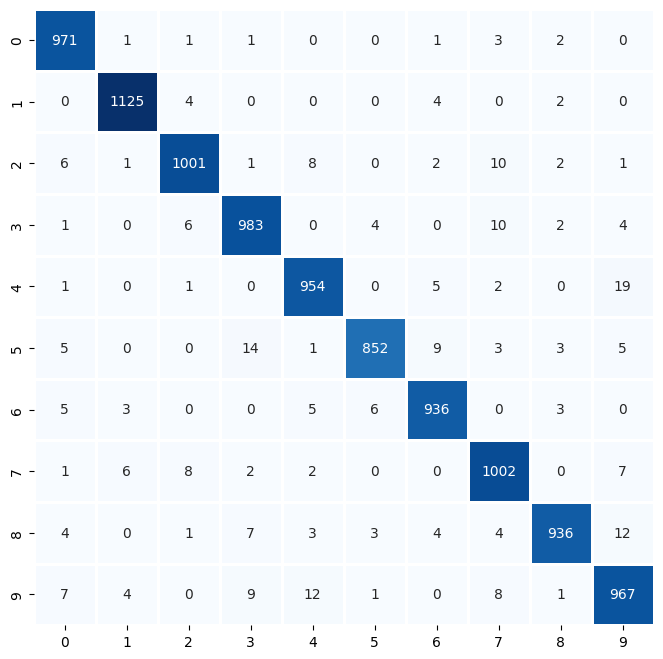

In [218]:
matrix_five = confusion_matrix(y_test,preds_five)
matrix_six = confusion_matrix(y_test,preds_six)
matrix_teven = confusion_matrix(y_test,preds_seven)
matrix_eight = confusion_matrix(y_test,preds_eight)

fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(matrix_five, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
# sns.heatmap(matrix_six, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
# sns.heatmap(matrix_teven, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
sns.heatmap(matrix_eight, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')

#### Experiment Set 3 - Feature Engineering

#### Experiment 9 - Feature Engineering via Pincipal Component Analysis (154 features)

In [184]:
# Experiment 9

# PCA FOR TRAINING SET
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)

# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values

pca = PCA(n_components=154)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

# Step 1 - Create model architecture using the Sequential class
model_nine = Sequential([
    Dense(input_shape=[154], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[64],units=32,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_nine.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_nine = model_nine.fit(
    principalComponents
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_nine.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_nine = tf.keras.models.load_model("model_nine.h5")

# REPEAT PCA FOR TEST SET

#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_test}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_test_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)

# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values

pca = PCA(n_components=154)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

# Step 4 - Predict the test set
preds_nine = model_nine.predict(principalComponents)
preds_nine = np.argmax(preds_nine, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 629us/step


#### Experiment 10 - Feature Engineering via Random Forest (70 features)

In [185]:
# Experiment 10

# Random Forest Classifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]

# Step 1 - Create model architecture using the Sequential class
model_ten = Sequential([
    Dense(input_shape=[70], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[64],units=32,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_ten.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_ten = model_ten.fit(
    train_images_sm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_ten.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=0
    )

# Step 3a - Load the best model
model_ten = tf.keras.models.load_model("model_ten.h5")

# Step 4 - Predict the test set
preds_ten = model_ten.predict(test_images_sm)
preds_ten = np.argmax(preds_ten, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 350us/step


#### Experiment Set 3 Results

In [219]:
experiment_set_3_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])
experiment_9_results = create_results_dataframe('model_nine',training_nine,y_test,preds_nine)
experiment_10_results = create_results_dataframe('model_ten',training_ten,y_test,preds_ten)
experiment_set_3_results = pd.concat([experiment_set_3_results,experiment_9_results,experiment_10_results]).reset_index(drop=True)
experiment_set_3_results

,model,epoch,accuracy,loss,precision_micro,recall_micro,f1_score_micro
0,model_nine,4,0.978083,0.180668,0.1394,0.1394,0.1394
1,model_ten,6,0.925500,0.376159,0.9168,0.9168,0.9168


<Axes: >

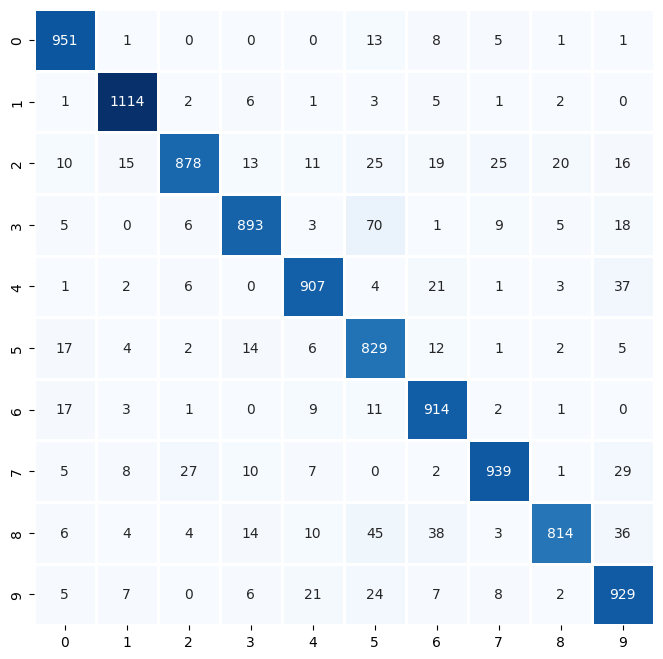

In [223]:
matrix_nine = confusion_matrix(y_test,preds_nine)
matrix_ten = confusion_matrix(y_test,preds_ten)

fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(matrix_nine, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
sns.heatmap(matrix_ten, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')